In [1]:
import numpy as np
import os
import sys

import torch
import torch.nn.functional as F
import torchvision.transforms as T
from torch import nn, Tensor

from functools import partial
from omegaconf import DictConfig
from tqdm.notebook import tqdm
from typing import Any, Callable, Dict, Iterable, List, Tuple

In [2]:
import cv2
import PIL

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [4]:
BASE_DIR = '/home/dmitry/projects/dfdc'
SRC_DIR = os.path.join(BASE_DIR, 'src')
HDF5_DIR = '/media/dmitry/other/dfdc-crops/hdf5'
IMG_DIR = '/media/dmitry/other/dfdc-crops/webp_lossy'

In [5]:
sys.path.insert(0, SRC_DIR)
sys.path.insert(0, './utils')

In [6]:
from dataset import HDF5Dataset, ImagesDataset, FrameSampler, BalancedSampler, simple_transforms
from dataset.transforms import image_grad
from visualise import show_images

In [7]:
from torch.utils.data import DataLoader, BatchSampler

In [8]:
sys.path.insert(0, os.path.join(SRC_DIR, 'train.py'))

In [9]:
from train import create_loader

In [10]:
conf = DictConfig(dict(
    type='hdf5',
    dir='/media/dmitry/other/dfdc-crops/hdf5',
    chunks='5 - 50',
    dir_list='',
    sample=dict(frames=10, real_fake_ratio=3.33, sparse_frames_prob=0.75),
    loader=dict(batch_size=16, workers=0),
    transforms=dict(
        resize_to=256, 
        hpf_order=3, 
        mean=[7.99074656e-10, 9.42090607e-10, 6.85161949e-10],
        std=[0.03253524, 0.03236544, 0.03264875])
))

In [11]:
# dl = create_loader(conf, 'train')

Num train samples: 110953


In [11]:
def create_loader(conf: Dict, transforms: Iterable[Callable],
                  dirs: Iterable[str]) -> DataLoader:
    num_frames = conf['frames']
    
    sampler = FrameSampler(num_frames, 
                           real_fake_ratio=conf['real_fake_ratio'],
                           p_sparse=conf['p_sparse'])
    
    ds = HDF5Dataset(HDF5_DIR,
                     frames=num_frames,
                     sampler=sampler,
                     transforms=transforms,
                     sub_dirs=dirs)
    print("Num samples: {}".format(len(ds)))

    batch_sampler = BatchSampler(BalancedSampler(ds),
                                 batch_size=conf['batch_size'],
                                 drop_last=True)
    num_workers = conf.get('loader.workers', 0)
    return DataLoader(ds, batch_sampler=batch_sampler, num_workers=num_workers)

In [17]:
conf = dict(
    real_fake_ratio=100/30, 
    p_sparse=1.0, 
    img_size=256, 
    frames=10,
    batch_size=16
)
dirs = ['dfdc_train_part_%d' % i for i in range(50)]

transforms = T.Compose([
    T.Lambda(lambda x: cv2.resize(x, (256, 256), interpolation=cv2.INTER_AREA)),
    T.ToTensor(),
    # T.Lambda(Tensor.cuda),
    T.Lambda(partial(image_grad, n=3, keep_size=True)),
#     T.Normalize(
#         mean=[7.99074656e-10, 9.42090607e-10, 6.85161949e-10],
#         std=[0.03253524, 0.03236544, 0.03264875]
#     )
])

In [18]:
dl = create_loader(conf, transforms, dirs)

Num samples: 118890


In [19]:
data_iter = iter(dl)

In [20]:
mean = np.array([0.0] * 3)
std = np.array([0.0] * 3)

for i in tqdm(range(len(dl))):
    x, y = next(data_iter)
    m, s = x.mean((0, 2, 3, 4)), x.std((0, 2, 3, 4))
    for c in range(3):
        mean[c] += m[c].item()
        std[c] += s[c].item()

In [21]:
mean/(i+1), std/(i+1)

(array([4.09008235e-10, 3.37999846e-10, 4.81442422e-10]),
 array([0.03264627, 0.03247622, 0.03276182]))

In [22]:
x.shape, x.device

(torch.Size([16, 3, 10, 256, 256]), device(type='cpu'))

In [23]:
# 100, 256px, n=3, cuda - 1:45s
# 100, 256px, n=3, cpu - 1:43s

In [24]:
images = x.permute(0, 2, 3, 4, 1)[:, 0].cpu().numpy()

In [25]:
images.clip(min=-1, max=1).min()

-0.91372526

In [26]:
images.max(), images.min()

(0.9058825, -0.91372526)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

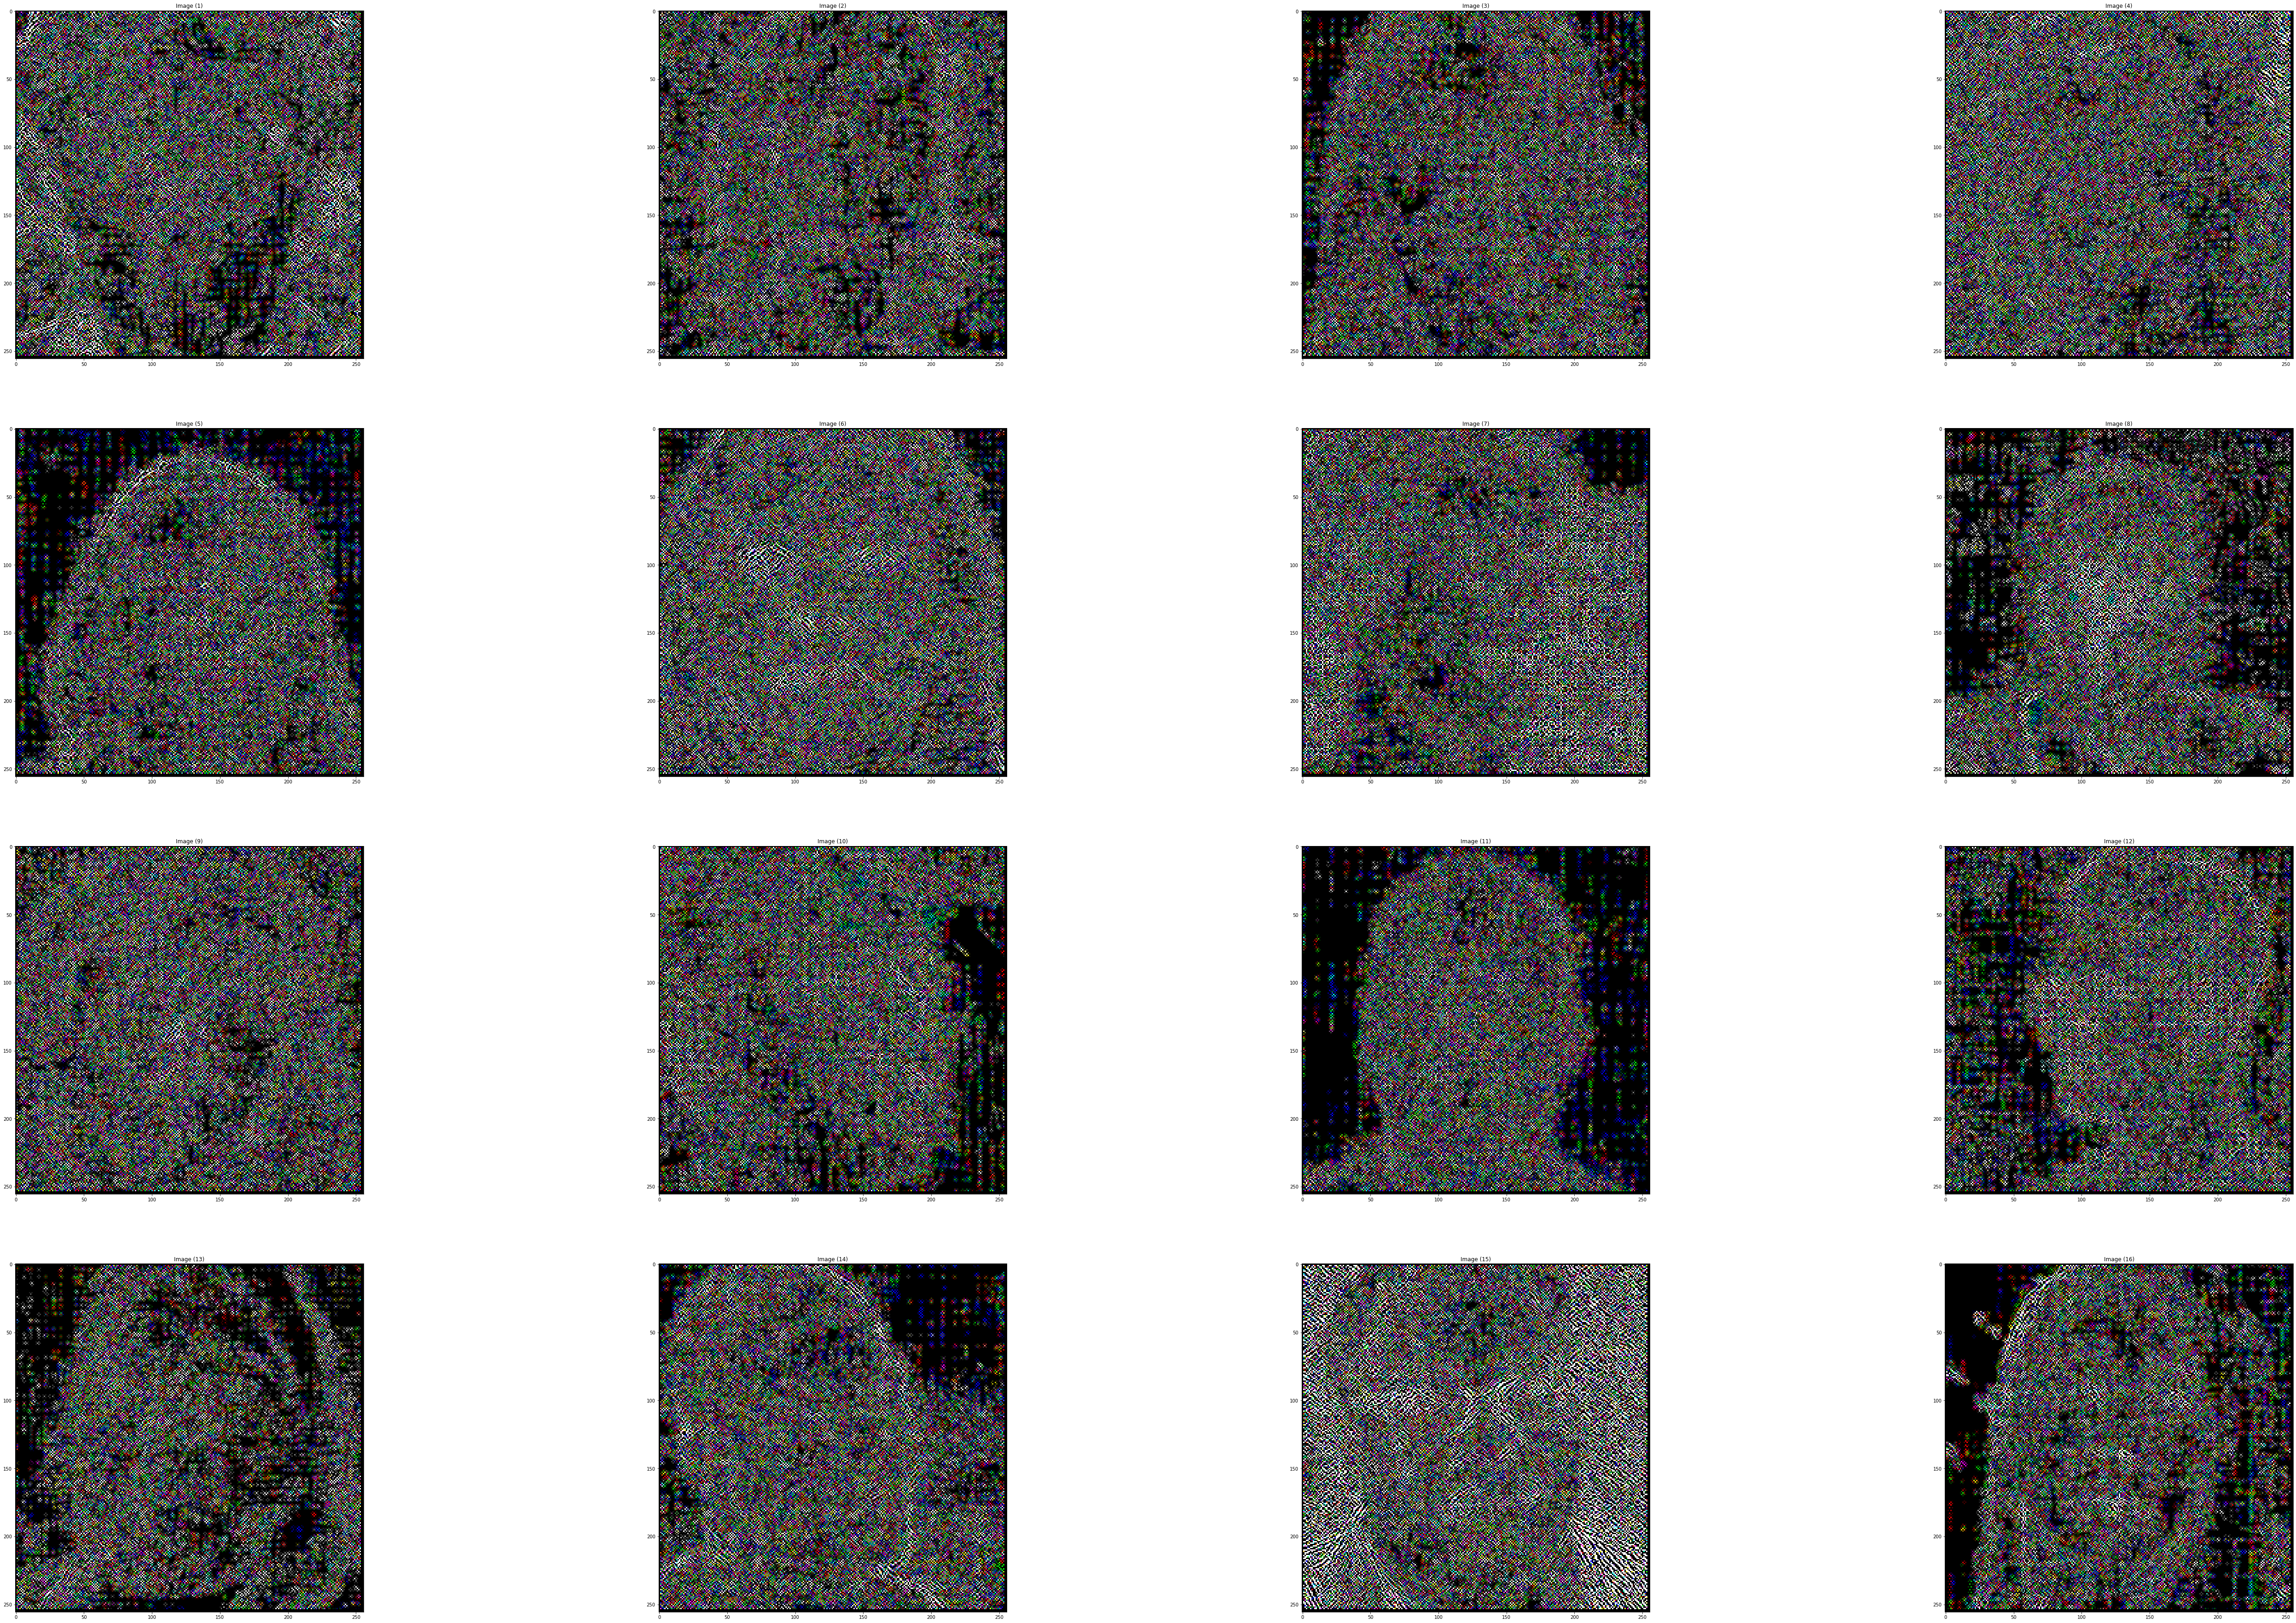

In [28]:
images = x.permute(0, 2, 3, 4, 1)[:, 0].cpu().numpy() * (i+1)/std
show_images(images, cols=len(images)//4)